# Auto-correlation --> velocity change over 2 days

In [1]:
import sys
sys.path.append(".")
sys.path.append("noisepy4das_repo/NoisePy4DAS-SeaDAS/src")
sys.path.append("noisepy4das_repo/NoisePy4DAS-SeaDAS/DASstore")

import os
import gc
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
import h5py
import math
import time
import DAS_module
import numpy as np
import pandas as pd
import matplotlib
import scipy.signal as sgn

from tqdm import tqdm
from obspy import UTCDateTime
from datetime import datetime
from datetime import timedelta
from functools import partial
from scipy.signal import butter
from scipy.signal import detrend
from scipy.signal import decimate
from scipy.signal import filtfilt
from scipy.signal import spectrogram
from scipy.interpolate import interp1d
from dasstore.zarr import Client
from multiprocessing import Pool
from matplotlib import pyplot as plt
from das_util import read_decimate, get_tstamp, calc_NFFT

%matplotlib inline
matplotlib.rcParams.update({'font.size': 16})


In [ ]:
def stretch(wave1, wave2, time, maxshift=0, max_ratio=2):

    interp_f = interp1d(time, wave2, bounds_error=False, fill_value=0.)
    n1 = np.sum(np.square(wave1))
    dt = time[1] - time[0]
    cc = 0
    relative_ratio = 1
    npts = len(time)

    for ratio in np.arange(1/max_ratio, max_ratio, 0.01):
        dt_new = dt / ratio
        time_new = np.arange(time[0], time[-1], dt_new)
        wave_new = interp_f(time_new)
        
        n2 = np.sum(np.square(wave_new))
        corr = sgn.correlate(wave1, wave_new) / np.sqrt(n1 * n2)

        l_maxshift = min(len(wave_new), maxshift)
        r_maxshift = min(len(wave1), maxshift)

        st_pt = len(wave_new) - l_maxshift
        en_pt = len(wave_new) + r_maxshift+1

        cc_best = np.nanmax(corr[st_pt: en_pt])

        if cc < cc_best:
            cc = cc_best
            relative_ratio = ratio

    dt_new = dt / relative_ratio
    time_new = np.arange(time[0], time[-1], dt_new)
    wave_new = interp_f(time_new)
    
    
    return wave_new, np.arange(len(wave_new))*dt, relative_ratio, cc

In [ ]:
def stretch_distribution(wave1, wave2, time, maxshift=0, max_ratio=2):

    stretch_range = np.arange(1/max_ratio, max_ratio, 0.01)
    
    interp_f = interp1d(time, wave2, bounds_error=False, fill_value=0.)
    n1 = np.sum(np.square(wave1))
    dt = time[1] - time[0]
    cc = np.zeros(len(stretch_range), dtype = np.float32)
    npts = len(time)

    for i, ratio in enumerate(stretch_range):
        dt_new = dt / ratio
        time_new = np.arange(time[0], time[-1], dt_new)
        wave_new = interp_f(time_new)
        
        n2 = np.sum(np.square(wave_new))
        corr = sgn.correlate(wave1, wave_new) / np.sqrt(n1 * n2)

        l_maxshift = min(len(wave_new), maxshift)
        r_maxshift = min(len(wave1), maxshift)

        st_pt = len(wave_new) - l_maxshift
        en_pt = len(wave_new) + r_maxshift+1

        cc[i] = np.nanmax(corr[st_pt: en_pt])
    
    return stretch_range, cc

## Sort 1-minute files by time

good acqusition for 2408 minutes


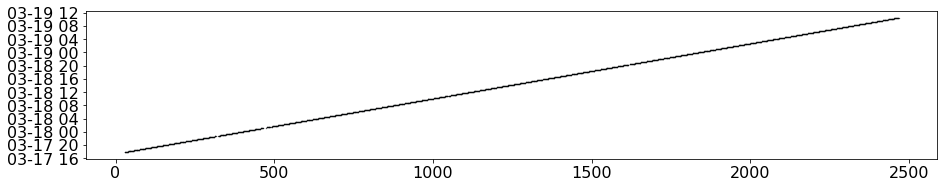

In [2]:
data_dir = '/1-fnp/petasaur/p-wd05/harper_plots'
file_list = np.array(os.listdir(data_dir))

acqu_time = np.array([get_tstamp(i) for i in file_list])
new_index = np.argsort(np.array(acqu_time)-acqu_time[0])
acqu_time = acqu_time[new_index]

file_list = file_list[new_index]
file_path = [os.path.join(data_dir,i) for i in file_list]

# %% reasonable acquisition time period
list_all = np.arange(28,2468)
num_sample_all = np.zeros(len(list_all), dtype=np.float64)
sample_rate_all = np.zeros(len(list_all), dtype=np.float64)
delta_space_all = np.zeros(len(list_all), dtype=np.float64)
for i,j in enumerate(list_all):
    with h5py.File(file_path[j],'r') as f:      
        num_sample_all[i]  = len(f['Acquisition']['Raw[0]']['RawDataTime'][:])
        sample_rate_all[i] = f['Acquisition']['Raw[0]'].attrs['OutputDataRate']
        delta_space_all[i] = f['Acquisition'].attrs['SpatialSamplingInterval']
        
# %% exclude files that dropped samples
ind_good = np.where(num_sample_all == 120000)[0]
list_all = list_all[ind_good]
delta_space = delta_space_all[ind_good][0]
num_sample = num_sample_all[ind_good][0]
sample_rate = sample_rate_all[ind_good][0]
delta_time = 1.0 / sample_rate

print(f'good acqusition for {len(ind_good)} minutes')

del num_sample_all, file_path
gc.collect()
# %% See if the acquisition time is continuous
file_list = file_list[list_all]
acqu_time = acqu_time[list_all]
file_path = [os.path.join(data_dir,i) for i in file_list]
plt.close('all')
fig, ax = plt.subplots(1, 1, figsize=(13, 2.5), constrained_layout=True)
ax.scatter(list_all, acqu_time.astype('datetime64[m]'), marker='o', s=0.1, edgecolors='k')

In [3]:
delta_space_all

array([3.19047627, 3.19047627, 3.19047627, ..., 3.19047627, 3.19047627,
       3.19047627])

In [ ]:
# locate the :30 time stamps in DAS
# hourly_index=[37,97,157,217,277,329,389,439,496,556,616,676,736,796,856,916,976,1033,1093,
#          1153,1213,1273,1332,1392,1452,1512,1569,1629,1689,1749,1809,1869,1929,1989,
#          2048,2108,2168,2228,2288]
# locate the :00 time stamps in DAS
hourly_index=[67,127,187,247,299,359,419,466,526,586,646,706,766,826,886,946,1003,1063,1123,
         1183,1243,1302,1362,1422,1482,1542,1599,1659,1719,1779,1839,1899,1959,2019,
         2078,2138,2198,2258,2318]
for i in hourly_index:
    print(acqu_time[i])

csv_file = pd.read_csv('NewportSalop_merged.csv', low_memory=False)
j = 32
# print(csv_file['Time'][j:j+40])
rainfall=csv_file[' Rainfall Total since 0900'][j:j+40].to_numpy()
rain_diff=np.diff(rainfall)

soil_temp_10=csv_file[' 10cm Soil Temperature'][j+1:j+40].to_numpy()
soil_temp_30=csv_file['30cm Soil Temperature'][j+1:j+40].to_numpy()
soil_temp_100=csv_file['100cm Soil Temperature'][j+1:j+40].to_numpy()
humidity=csv_file['Humidity'][j+1:j+40].to_numpy()
print(csv_file['Time'][32:72].to_numpy())
len(soil_temp_10)

## Auto correlation --multi-channel, multi-frequency

In [ ]:
start_file = np.arange(0, len(acqu_time), 5)
time_stamps = acqu_time[start_file]

samp_freq = 500                # targeted sampling rate
freq_norm   = 'no'             # 'no' for no whitening, or 'rma' for running-mean average, 'phase_only' for sign-bit normalization in freq domain.
time_norm   = 'one_bit'        # 'no' for no normalization, or 'rma', 'one_bit' for normalization in time domain
cc_method   = 'xcorr'          # 'xcorr' for pure cross correlation, 'deconv' for deconvolution; FOR "COHERENCY" PLEASE set freq_norm to "rma", time_norm to "no" and cc_method to "xcorr"
smooth_N    = 50               # moving window length for time domain normalization if selected (points)
smoothspect_N  = 50            # moving window length to smooth spectrum amplitude (points)
maxlag      = 5                # lags of cross-correlation to save (sec)

# criteria for data selection
max_over_std = 10 *9              # threshold to remove window of bad signals: set it to 10*9 if prefer not to remove them
num_sample = 30000
cc_len = delta_time * num_sample  # correlate length in second
step   = delta_time * num_sample  # stepping length in second

n_pair = 1
n_lag = maxlag * samp_freq * 2 + 1

In [ ]:
######### Loop over frequency
# for freqmin in [1,2,3,4,5,6,7,8,9,10,15,20,30,40]:
for freqmin in [25]:
    freqmax = freqmin * 2
    
    locations = np.arange(44,95,1)
    corr_all_time = np.zeros((len(locations), len(start_file), n_lag, n_pair), dtype = np.float32)
    
    ######### Loop over channel
    for loc, auto_ch in enumerate(locations):

        # start and end channel index for the sub-array
        cha1 = auto_ch
        cha2 = auto_ch + 1
        cha_list = np.array(range(cha1, cha2)) 
        nsta = len(cha_list)

        prepro_para = {'freqmin':freqmin,
                       'freqmax':freqmax,
                       'sps':sample_rate,
                       'npts_chunk':cc_len*sample_rate,
                       'nsta':nsta,
                       'cha_list':cha_list,
                       'samp_freq':samp_freq,
                       'freq_norm':freq_norm,
                       'time_norm':time_norm,
                       'cc_method':cc_method,
                       'smooth_N':smooth_N,
                       'smoothspect_N':smoothspect_N,
                       'maxlag':maxlag,
                       'max_over_std':max_over_std}
        
        ######### Loop over time windows
        for i,iquake in enumerate(tqdm(start_file)):
            corr_full = np.zeros((n_lag, n_pair), dtype = np.float32)
            stack_full = np.zeros((1, n_pair), dtype = np.int32)
            
            for j in [0, 15, 30, 45]:
                st_samp = int(j * samp_freq)
            
                with h5py.File(file_path[iquake],'r') as f:
                    minute_data = f['Acquisition']['Raw[0]']['RawData'][st_samp:st_samp+num_sample, cha1:cha2]

                # perform pre-processing
                trace_stdS, dataS = DAS_module.preprocess_raw_make_stat(minute_data, prepro_para)

                # do normalization if needed
                white_spect = DAS_module.noise_processing(dataS, prepro_para)
                Nfft = white_spect.shape[1]
                data = white_spect[:, :(Nfft // 2)]

                del dataS, white_spect
                gc.collect()

                ind = np.where((trace_stdS < prepro_para['max_over_std']) &
                               (trace_stdS > 0) &
                      (np.isnan(trace_stdS) == 0))[0]
                if not len(ind):
                    raise ValueError('no data- reduce max_over_std')
                sta = cha_list[ind]
                white_spect = data[ind]

                for iiS in range(len(sta)):
                    # smooth the source spectrum
                    sfft1 = DAS_module.smooth_source_spect(white_spect[iiS], prepro_para)
                    # Xcorr
                    corr, tindx = DAS_module.correlate(sfft1, white_spect[iiS:], prepro_para, Nfft)
                    tsta = sta[iiS:]
                    receiver_lst = tsta[tindx]
                    iS = int((cha2*2 - cha1 - sta[iiS] + 1) * (sta[iiS] - cha1) / 2)

                    # sub-stack
                    corr_full[:, iS + receiver_lst - sta[iiS]] += corr.T / np.var(sfft1)/len(corr)
                    stack_full[:, iS + receiver_lst - sta[iiS]] += 1

            corr_full /= stack_full

            corr_all_time[loc, i,:,:] = corr_full

        plt.figure(figsize = (12, 4), dpi = 200)
        data_plot=corr_all_time[loc, :, 2500:2650, 0].T
        x=np.arange(data_plot.shape[1])
        y=np.arange(data_plot.shape[0])
        xts=np.array(time_stamps)
        xhrs=np.round((xts - xts[0]).astype('float')/3600, 2)

        plt.pcolormesh(x, y, data_plot, shading='auto', vmin=-0.4, vmax=0.4, cmap = 'RdBu')

        plt.yticks(np.arange(0, data_plot.shape[0], 25), 
                   (np.arange(0, data_plot.shape[0], 25))/samp_freq, fontsize = 12)
        plt.xticks(np.arange(0, data_plot.shape[1],100), xhrs[:data_plot.shape[1]:100], fontsize = 12)

        plt.xlabel("ACF time (hour)", fontsize = 16)
        plt.ylabel("Time lag (sec)", fontsize = 16)
        plt.title('Channel '+str(auto_ch)+ '_' + str(freqmin)+'_'+str(freqmax)+'Hz', fontsize = 20)
        bar = plt.colorbar()
        bar.set_label('Auto-correlation Coefficient', fontsize = 15)
        
    # Save all ACFs
    with h5py.File('/fd1/QibinShi_data/England_farm/autocorr_' + str(freqmin) + '_' + str(freqmax) + 'Hz.hdf5', 'w') as f:
        f.create_dataset("autocorr", data=corr_all_time)

In [ ]:
del corr_all_time
gc.collect()

In [ ]:
win_st = int(0.012*samp_freq)

with h5py.File('/fd1/QibinShi_data/England_farm/autocorr_25_50Hz.hdf5', 'r') as f:
    corr_all_time = f['autocorr'][:, :, 2500:3000, 0]
    
for iloc in range(51):
    data_plot=corr_all_time[iloc].T
    x=np.arange(data_plot.shape[1])
    y=np.arange(data_plot.shape[0])
    xts=np.array(time_stamps)
    xhrs=np.round((xts - xts[0]).astype('float')/3600, 2)
    plt.figure(figsize = (10, 3), dpi = 200)
    for i in x[::5]:
        plt.plot(y/samp_freq, data_plot[:,i])

    plt.plot(y/samp_freq, np.mean(data_plot, axis=1), c='k', lw=9, alpha=0.3, label='mean of all')

    plt.legend()
    plt.title('channel '+ str(iloc+44))
    plt.xlabel('lag time (s)')
    plt.axvline(x=win_st/samp_freq, color='k', linestyle='--', label='1st reflection')


In [ ]:
# time = y[win_st:] / samp_freq
time = y[:] / samp_freq
stack_stretch=np.zeros((51, len(time)), dtype = np.float32)
for iloc in range(51):
    data_plot=corr_all_time[iloc].T
    x=np.arange(data_plot.shape[1])
    y=np.arange(data_plot.shape[0])
#     trunc_acf = data_plot[win_st:, :]
    trunc_acf = data_plot[:, :]
    trunc_stk = np.mean(trunc_acf, axis=1)
    
    count = 0
    plt.figure(figsize = (10, 3), dpi = 200)
    for i in x[::5]:
        tmp=np.zeros_like(time)
        stretched, time_new, ratio, cc = stretch(trunc_stk, trunc_acf[:,i], time, max_ratio=2)
        if cc > 0.5:
            length=min(len(stretched), len(time))
            tmp[:length]=stretched[:length]
            stack_stretch[iloc, :] += tmp
            plt.plot(time, tmp)
            count +=1
        else:continue
    plt.plot(time, stack_stretch[iloc, :]/count, c='k', lw=9, alpha=0.5, label='mean of all')
    plt.title('channel '+ str(iloc+44)); plt.legend(); plt.xlabel('lag time (s)')

In [ ]:
all_ratio = np.zeros((51, len(x)), dtype = np.float32)
all_cc = np.zeros((51, len(x)), dtype = np.float32)
freqmin = 25
freqmax = freqmin*2

all_ch_strecthed_acfs = []

for iloc in range(51):
    data_plot=corr_all_time[iloc].T
#     trunc_acf = data_plot[win_st:, :]
    trunc_acf = data_plot[:, :]
    trunc_stk = stack_stretch[iloc, :]/count
    strecthed_acfs = np.zeros_like(trunc_acf)
    for i in x:
        stretched, time_new, ratio, cc = stretch(trunc_stk, trunc_acf[:,i], time, max_ratio=1.5)
        length=min(len(stretched), len(time))
        strecthed_acfs[:length, i] = stretched[:length]

        all_ratio[iloc, i] = ratio
        all_cc[iloc, i] = cc
        
    all_ch_strecthed_acfs.append(strecthed_acfs)
    
#     plt.figure(figsize = (12, 5), dpi = 200)
#     plt.pcolormesh(x, time, strecthed_acfs, shading='auto', vmin=-0.2, vmax=0.2, cmap = 'RdBu')

#     plt.xticks(np.arange(0, data_plot.shape[1],100), xhrs[:data_plot.shape[1]:100], fontsize = 12)

#     plt.xlabel("ACF time (hour)", fontsize = 16)
#     plt.ylabel("Time lag (sec)", fontsize = 16)
#     plt.title('channel '+ str(iloc+44)+ '_' + str(freqmin)+'_'+str(freqmax)+'Hz', fontsize = 20)
#     bar = plt.colorbar()
#     bar.set_label('Auto-correlation Coefficient', fontsize = 15)
    


In [ ]:
def stack_2d_arrays_to_3d(arr_list):
    """
    Convert a list of 2D NumPy arrays into one 3D NumPy array.

    Parameters:
    arr_list (list): List of 2D NumPy arrays.

    Returns:
    np.ndarray: 3D NumPy array.
    """
    # Check if the input list is empty
    if len(arr_list) == 0:
        raise ValueError("Input list is empty")

    # Determine the shape of the output 3D array
    num_arrays = len(arr_list)
    shape_2d = (np.max([arr.shape[0] for arr in arr_list]), np.max([arr.shape[1] for arr in arr_list]))
    shape_3d = (num_arrays, shape_2d[0], shape_2d[1])

    # Initialize the 3D array with zeros
    result = np.zeros(shape_3d, dtype=np.float64)

    # Stack the 2D arrays along the first dimension to create a 3D array
    for i, arr in enumerate(arr_list):
        result[i, :arr.shape[0], :arr.shape[1]] = arr

    return result

In [ ]:
all_ch_strecthed_acfs_np = stack_2d_arrays_to_3d(all_ch_strecthed_acfs)

In [ ]:
all_ch_strecthed_acfs_np.shape
# corr_all_time.shape

In [ ]:
# Save all ACFs
with h5py.File('/fd1/QibinShi_data/England_farm/autocorr_' + str(freqmin) + '_' + str(freqmax) + 'Hz_stretched.hdf5', 'w') as f:
    f.create_dataset("autocorr", data=all_ch_strecthed_acfs_np)

In [ ]:
# Save all stretch ratio and CC
with h5py.File('dvv_stretch_cc_' + str(freqmin) + '_' + str(freqmax) + 'Hz.hdf5', 'w') as f:
    f.create_dataset("ratio", data=all_ratio)
    f.create_dataset("cc", data=all_cc)
    
for iloc in range(51):
    plt.figure(figsize = (10, 2), dpi = 200)

    plt.scatter(x, all_ratio[iloc], cmap='viridis', c=np.array(all_cc[iloc]), s=20, marker='o')
    plt.xticks(np.arange(0, data_plot.shape[1],100), xhrs[:data_plot.shape[1]:100], fontsize = 12)
    plt.colorbar()
    plt.xlabel('time (hour)')
    plt.ylabel('stretch ratio')
    plt.title('channel '+ str(iloc+44)+ '_' + str(freqmin)+'_'+str(freqmax)+'Hz', fontsize = 20)

## Calculate PSD for each 1-min file

In [ ]:
with h5py.File(file_path[200],'r') as f:
    minute_data = f['Acquisition']['Raw[0]']['RawData'][:, 74]
    sample_rate = f['Acquisition']['Raw[0]'].attrs['OutputDataRate']
    dsamp_data = decimate(minute_data, q=5, ftype='fir', zero_phase=True)
freq, psd = sgn.welch(dsamp_data, sample_rate/5)
freq1,psd1=sgn.periodogram(dsamp_data, sample_rate/5)
freq2, psd2=sgn.csd(dsamp_data,dsamp_data,sample_rate/5)

plt.semilogy(freq1, psd1)
# plt.xlim(0,200)
plt.title('Power Spectral Density')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency (dB/Hz)')

plt.semilogy(freq2, psd2)
# plt.xlim(0,200)
plt.title('Power Spectral Density')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency (dB/Hz)')


In [ ]:
freq.shape

In [ ]:
start_file = np.arange(0, len(acqu_time), 1)
time_stamps = acqu_time[start_file]
    
locations = np.arange(44,46,2)
PSD_all_time = np.zeros((len(locations), len(start_file), len(psd)), dtype = np.float32)

for loc, ch in enumerate(locations):
    for i,iquake in enumerate(tqdm(start_file)):
        with h5py.File(file_path[iquake],'r') as f:
            minute_data = f['Acquisition']['Raw[0]']['RawData'][:, ch]
            dsamp_data = decimate(minute_data, q=5, ftype='fir', zero_phase=True)
        freq, psd = sgn.welch(dsamp_data, sample_rate/5)
        PSD_all_time[loc, i,:] = psd
    plt.figure(figsize = (12, 4), dpi = 200)
    data_plot=PSD_all_time[loc, :, :].T

    plt.pcolormesh(np.arange(2408), freq, data_plot, shading='auto', vmin=0, vmax=0.001, cmap = 'viridis')
#     plt.xticks(np.arange(0, data_plot.shape[1],100), xhrs[:data_plot.shape[1]:100], fontsize = 12)
    plt.xlabel("ACF time (hour)", fontsize = 16)
    plt.ylabel("Frequency (Hz)", fontsize = 16)
    plt.title('Channel '+str(ch), fontsize = 20)
    plt.ylim(0,200)
    bar = plt.colorbar()
    bar.set_label('Power Spectral Density', fontsize = 15)
    # Save all ACFs
    with h5py.File('/fd1/QibinShi_data/England_farm/psd_ch_' + str(ch) + '.hdf5', 'w') as f:
        f.create_dataset("psd_all_time", data=PSD_all_time)
        f.create_dataset("frequency", data=freq)

In [ ]:
time_psd=np.sum(PSD_all_time[:, :, 52:90], axis=-1)
ave_psd=np.mean(time_psd, axis=0)

for loc, ch in enumerate(locations):
    plt.figure(figsize = (12, 4), dpi = 200)
    
    plt.plot(np.arange(time_psd[loc].shape[-1]), time_psd[loc])
#     plt.xticks(np.arange(0, data_plot.shape[1],100), xhrs[:data_plot.shape[1]:100], fontsize = 12)

    plt.xlabel("ACF time (hour)", fontsize = 16)
    plt.ylabel("Sum of PSD", fontsize = 16)
    plt.title('Channel '+str(ch), fontsize = 20)

In [ ]:
## smoothing over 1 hr window
hr_psd=[]
for ind in hourly_index:
    st_ind = int(ind - 60)
    ed_ind = st_ind + 60
    psd_int=np.sum(ave_psd[st_ind:ed_ind])
    
    hr_psd.append(psd_int)

plt.figure(figsize = (12, 4), dpi = 200)   
plt.scatter(hourly_index, rain_diff/2.3, label='1 hr rain', color='g', marker='o', s=100)
plt.scatter(hourly_index, np.array(hr_psd), label='1 hr psd', color='b', marker='*', s=100)
plt.plot(hourly_index, np.array(hr_psd))
plt.plot(np.arange(ave_psd.shape[-1]), ave_psd*5, label='psd')
# plt.xticks(np.arange(0, data_plot.shape[1],100), xhrs[:data_plot.shape[1]:100], fontsize = 12)

plt.xlabel("ACF time (min)", fontsize = 16)
plt.ylabel("Sum of PSD", fontsize = 16)
plt.title('Channel-wise average, hourly stack', fontsize = 20)  
plt.ylim(-0.2, 2)
plt.legend()

np.argmax(rain_diff)

In [ ]:
# Stretch again to get distribution
stretch_range = np.arange(1/2, 2, 0.01)
all_ratio = np.zeros((51, len(stretch_range), len(x)), dtype = np.float32)
all_cc = np.zeros((51, len(stretch_range), len(x)), dtype = np.float32)
for iloc in [18, 30]:
    data_plot=corr_all_time[iloc].T
    trunc_acf = data_plot[win_st:, :]
    trunc_stk = stack_stretch[iloc, :]/count
    strecthed_acfs = np.zeros_like(trunc_acf)
    for i in x:
        ratios, ccs = stretch_distribution(trunc_stk, trunc_acf[:,i], time, max_ratio=2)
        all_cc[iloc, :, i] = ccs  
    plt.figure(figsize = (12, 3), dpi = 100)
    plt.pcolormesh(x, stretch_range, all_cc[iloc], shading='auto', vmin=0.2, vmax=1, cmap = 'hot')
    plt.xticks(np.arange(0, data_plot.shape[1],100), xhrs[:data_plot.shape[1]:100], fontsize = 12)
    plt.xlabel("ACF time (hour)", fontsize = 16)
    plt.ylabel("stretch ratio", fontsize = 16, color='r')
    plt.ylim(0.5, 1.5)
    plt.title('channel '+ str(iloc+44)+ '_' + str(freqmin)+'_'+str(freqmax)+'Hz', fontsize = 20)
    bar = plt.colorbar()
    bar.set_label('Cross-correlation Coefficient', fontsize = 15)
    
    axcopy = plt.twinx()
    axcopy.scatter(np.array(hourly_index)/5, soil_temp_10-7.5, label='T_10cm', color='w', marker='^')
    axcopy.scatter(np.array(hourly_index)/5, (soil_temp_30-7.5), label='T_30cm', color='w', marker='s')
    axcopy.scatter(np.array(hourly_index)/5, (soil_temp_100-7.5), label='T_100cm', color='w', marker='v')
    axcopy.scatter(np.array(hourly_index)/5, rain_diff*1.2, label='1hr rain', color='g', marker='o', s=100)
    axcopy.scatter(np.array(hourly_index)/5, 4-(humidity-63)/12, label='dryness', color='g', marker='+', s=100)
#     axcopy.plot(x, ave_psd*10, label='sum_psd')
#     axcopy.scatter(np.array(hourly_index)/5, np.array(hr_psd)*8, label='hr_psd', color='b', marker='d', s=100)
    axcopy.legend(fontsize = 7)
    axcopy.set_ylim(-0.2,4)